In [52]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision import datasets
from torchvision.transforms import ToTensor

plt.rc('image', cmap='Greys')

In [53]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [54]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [55]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

In [56]:
train_data_by_label = [[] for i in range(10)]

for x, y in train_data:
    train_data_by_label[y].append(x)

for i in range(len(train_data_by_label)):
    if len(train_data_by_label[i]) != 6000:
        print('Error. Unexpected length.')
print('All good!')

All good!


## Generating mean items

The mean items are created by getting the mean of all the tensors in each category of the training dataset.

It takes the average of each pixel for all the images in each category.

In [57]:
mean_items = [None for i in range(10)]
samples = [None for i in range(10)]
sample_index = 0

for label in range(10):
    stacked = torch.stack(train_data_by_label[label]).squeeze()
    samples[label] = stacked[sample_index]
    mean = stacked.mean(0)
    mean_items[label] = mean

## Try it yourself:
Change `sample_index` to see different samples

# Samples

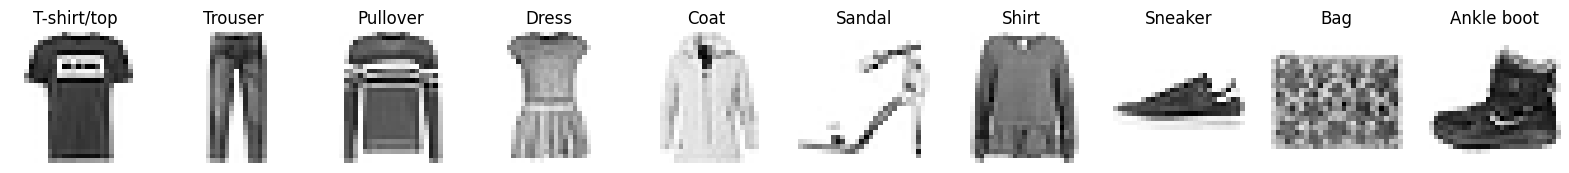

In [58]:
fig, axs = plt.subplots(1, 10, figsize=(20,10))
axs = axs.ravel()

for i in range(10):
    axs[i].imshow(samples[i])
    axs[i].set_title(f'{classes[i]}')
    axs[i].axis('off')
    
plt.show()

# Mean items

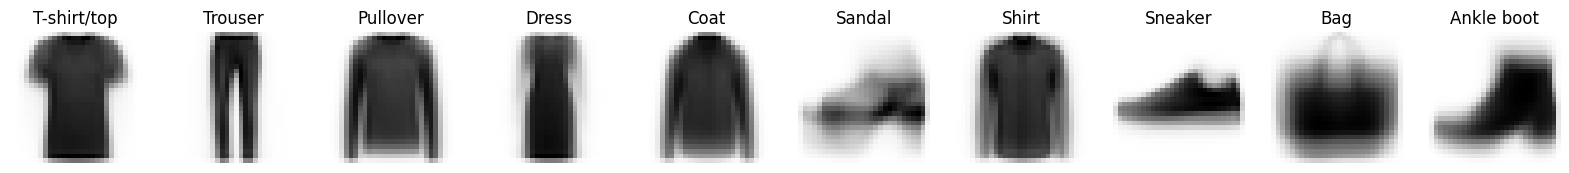

In [59]:
fig, axs = plt.subplots(1, 10, figsize=(20,10))
axs = axs.ravel()

for i in range(10):
    axs[i].imshow(mean_items[i])
    axs[i].set_title(f'{classes[i]}')
    axs[i].axis('off')
    
plt.show()

In [60]:
def mnist_distance(a, b): return (a - b).abs().mean((-1, -2))

In [61]:
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [62]:
test_data_by_label = [[] for i in range(10)]

for x, y in test_data:
    test_data_by_label[y].append(x)

for i in range(len(test_data_by_label)):
    if len(test_data_by_label[i]) != 1000:
        print('Error. Unexpected length.')
print('All good!')

All good!


# Samples from a category

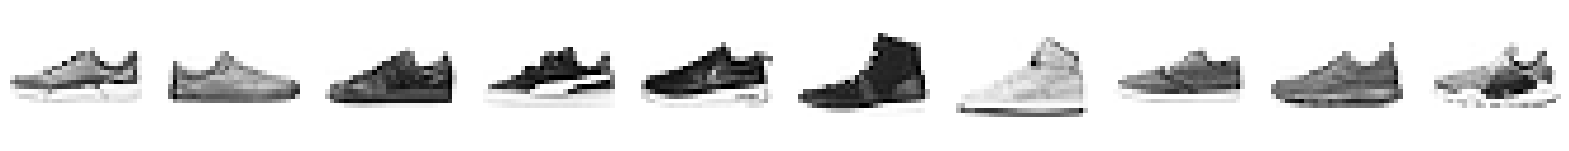

In [63]:
category_index = 7 # 7 is the label for sneakers
first_images = test_data_by_label[category_index][0:10]

fig, axs = plt.subplots(1, 10, figsize=(20,10))
axs = axs.ravel()

for i in range(10):
    axs[i].imshow(first_images[i].squeeze())
    axs[i].axis('off')
    
plt.show()

## Try it yourself:
Change `category_index` to see samples from a different category

In [64]:
all_distances = []

# loop through categories
for i in range(10):
    category_distances = []
    category_test_images = torch.stack(test_data_by_label[i])
    
    # loop through means for each category
    for j in range(10):
        distance = mnist_distance(category_test_images, mean_items[j])
        category_distances.append(distance)
    
    # all images of a given category were tested against all mean items
    all_distances.append(torch.stack(category_distances).transpose(0,1))
    
all_distances = torch.stack(all_distances)

In [65]:
accuracy_by_label = []

for category in range(10):
    accuracy = [1 if torch.argmin(all_distances[category][image]) == category else 0 for image in range(1000)]
    accuracy_by_label.append(np.mean(accuracy))

# Accuracy breakdown by category

In [66]:
for i in range(10):
    print(f'{classes[i]}: {accuracy_by_label[i]}')

T-shirt/top: 0.623
Trouser: 0.933
Pullover: 0.254
Dress: 0.702
Coat: 0.656
Sandal: 0.529
Shirt: 0.18
Sneaker: 0.918
Bag: 0.513
Ankle boot: 0.816


# Average accuracy of the baseline

In [67]:
baseline_accuracy = np.mean(accuracy_by_label)
baseline_accuracy

0.6123999999999999

## Looking at *confusions* 

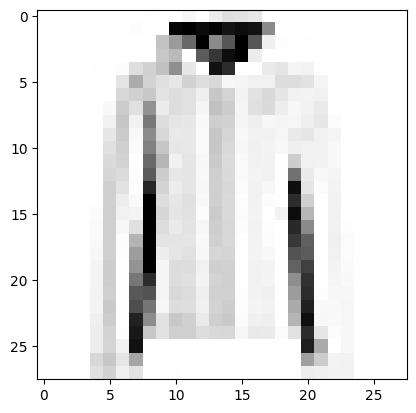

In [79]:
a_coat, a_coat_label = test_data[6]
plt.imshow(a_coat.squeeze())

This coat is so light, it looks closer to the average sandal in the pixel comparison

In [69]:
coat_distances = []

for i in range(10):
  coat_distances.append(mnist_distance(a_coat, mean_items[i]))

print(f'\nBaseline with pixel comparison\nPredicted: {classes[torch.argmin(torch.stack(coat_distances))]}, Actual: {classes[a_coat_label]}')


Baseline with pixel comparison
Predicted: Sandal, Actual: Coat


---

# Using a neural network

In [70]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

In [71]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [72]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        if device != "cpu":
            X, y = X.to(device), y.to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}, [{current:>5d}/{size:>5d}]")

In [73]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [74]:
train_dataloader = DataLoader(train_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

In [24]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.311673, [   64/60000]
loss: 2.299227, [ 6464/60000]
loss: 2.281137, [12864/60000]
loss: 2.263207, [19264/60000]
loss: 2.245568, [25664/60000]
loss: 2.232702, [32064/60000]
loss: 2.222782, [38464/60000]
loss: 2.201670, [44864/60000]
loss: 2.190649, [51264/60000]
loss: 2.168225, [57664/60000]
Test error: 
 Accuracy: 48.2%, Avg loss: 2.157065 

Epoch 2
-------------------------------
loss: 2.168553, [   64/60000]
loss: 2.155025, [ 6464/60000]
loss: 2.096412, [12864/60000]
loss: 2.110275, [19264/60000]
loss: 2.053044, [25664/60000]
loss: 2.018328, [32064/60000]
loss: 2.030789, [38464/60000]
loss: 1.961182, [44864/60000]
loss: 1.955887, [51264/60000]
loss: 1.900697, [57664/60000]
Test error: 
 Accuracy: 58.7%, Avg loss: 1.886838 

Epoch 3
-------------------------------
loss: 1.918088, [   64/60000]
loss: 1.884685, [ 6464/60000]
loss: 1.763732, [12864/60000]
loss: 1.812748, [19264/60000]
loss: 1.689504, [25664/60000]
loss: 1.666705, [32064/600

In [83]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [93]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

## Next experiments

- Using the fast.ai Learner
- Batching the baseline calculations